In [1]:

import importlib
import data_prep as dp
import pandas as pd
importlib.reload(dp)
print(dir(dp))  # Check if functions appear now

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Device set to use mps:0
Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [2]:
import matplotlib.pyplot as plt

In [3]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

In [604]:
df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv')

In [605]:
df.index = pd.to_datetime(df['date'])

In [606]:
import statsmodels.api as sm
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression


df['mean_sentiment_decay'] = df['overall_mean'].shift(1)  # Decay from yesterday
df['shock_pos'] = df['overall_max'] #best new
df['shock_neg'] = df['overall_min'] #worst new 
df['sentiment_dominance'] = df['summary_pos_count'] - df['summary_neg_count'] # which type of new is more prevalent (p/n)?
df['dominance_trigger'] = (df['sentiment_dominance'] < -5).astype(int) #if one type of news is more prevalent than the other, it will trigger a shock
df['vix_7d_pct'] = df['vix_target'].pct_change(15)
df['vix_zscore'] = (df['vix_target'] - df['vix_target'].rolling(30).mean()) / df['vix_target'].rolling(30).std()





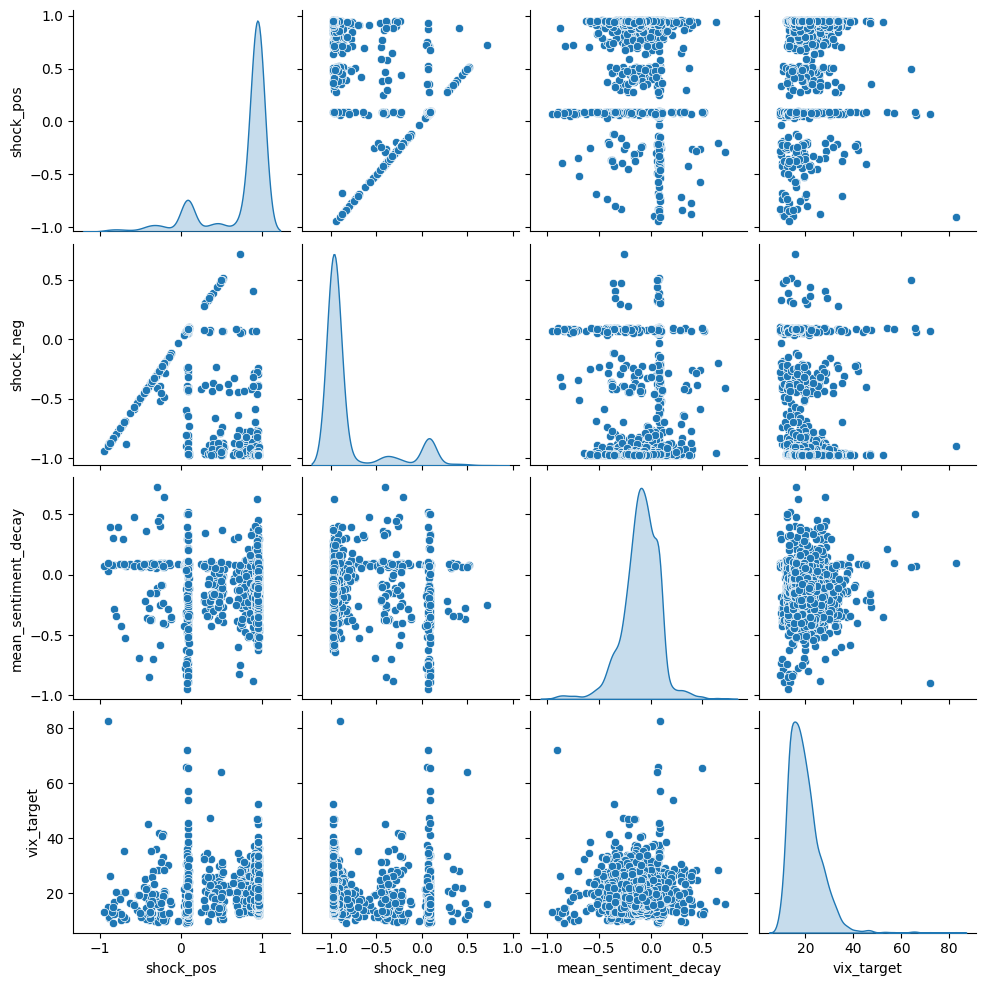

In [235]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target'], diag_kind='kde')


In [607]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]


In [608]:

df.index = pd.to_datetime(df.index)

# Train: Post-COVID to end of 2023
train_df = df[(df.index >= "2020-06-01") & (df.index <= "2023-12-31")]

# Test: Recent years
test_df = df[df.index >= "2024-01-01"]


print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[0] + ['vix_target']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_target']

model = MarkovRegression(y, exog=X, k_regimes=2, switching_variance=False)
results = model.fit(disp=False)
print(f"Features: {feature_sets[0]}")
print(f"AIC: {results.aic:.3f}, LogL: {results.llf:.3f}")
print(results.summary().tables[0])
print("-" * 80)


Train set: 1204 rows
Test set: 458 rows


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Features: ['shock_neg', 'dominance_trigger']
AIC: 6358.814, LogL: -3170.407
                        Markov Switching Model Results                        
Dep. Variable:             vix_target   No. Observations:                 1204
Model:               MarkovRegression   Log Likelihood               -3170.407
Date:                Tue, 15 Apr 2025   AIC                           6358.814
Time:                        12:56:37   BIC                           6404.655
Sample:                             0   HQIC                          6376.079
                               - 1204                                         
Covariance Type:               approx                                         
--------------------------------------------------------------------------------


In [609]:
import numpy as np

P_00 = results.params['p[0->0]']       # P(stay in regime 0)
P_10 = results.params['p[1->0]']       # P(switch from regime 1 to 0)
P_01 = 1 - P_00                       # P(switch from regime 0 to 1)
P_11 = 1 - P_10                       # P(stay in regime 1)

transition_matrix = np.array([
    [P_00, P_01],  # from regime 0
    [P_10, P_11]   # from regime 1
])

print("Transition Matrix:")
print(transition_matrix)





Transition Matrix:
[[0.98573887 0.01426113]
 [0.02405682 0.97594318]]


In [610]:
# Get the most likely regime at each time step
df_model['regime_t'] = results.smoothed_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.015 else 0)
selected_features = feature_sets[0]

In [611]:
df_model['vix_target_t+1'] = df_model['vix_target'].shift(-1) #lag for predicting the vix level, not the regime prediction

regime_col = df_model['regime_t'].copy() #so that it doesnt erase

df_model = df_model.dropna(subset=selected_features + ['vix_target_t+1']).copy()

df_model['regime_t'] = regime_col.loc[df_model.index]


X = df_model[selected_features]
y = df_model['vix_target_t+1']

model2 = MarkovRegression(
    endog=y,
    exog=X,
    k_regimes=2,
    switching_variance=False
)
results2 = model2.fit() #model for predicting the vix level t+1


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [612]:
print(results2.summary())

                        Markov Switching Model Results                        
Dep. Variable:         vix_target_t+1   No. Observations:                 1203
Model:               MarkovRegression   Log Likelihood               -3169.294
Date:                Tue, 15 Apr 2025   AIC                           6356.588
Time:                        12:56:39   BIC                           6402.422
Sample:                             0   HQIC                          6373.851
                               - 1203                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.8906      0.751     27.824      0.000      19.419      22.362
x1             3.2840      0.789      4.163      0.0

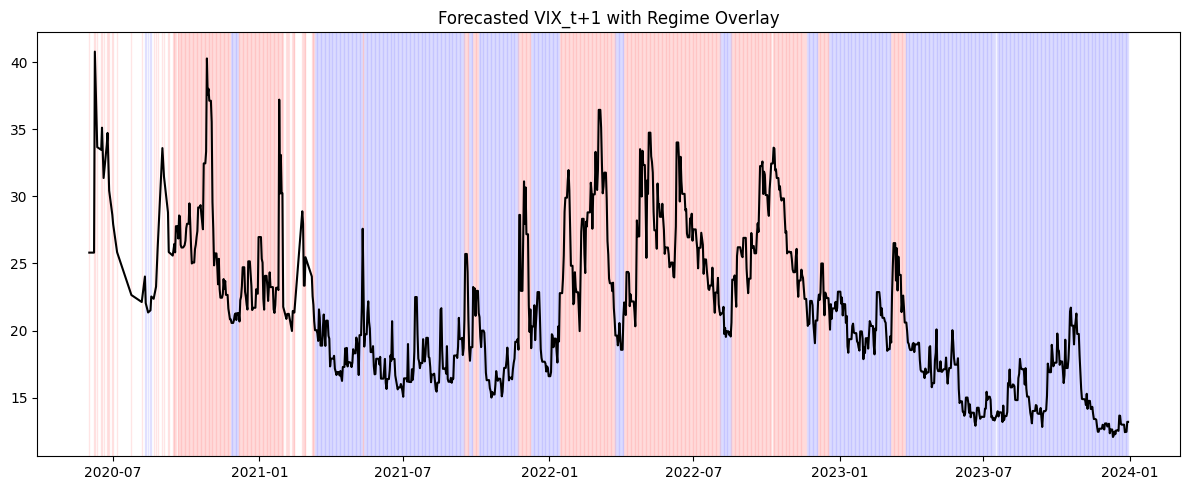

In [613]:
import matplotlib.pyplot as plt #graph vix t+1 with regime overlay

df_model['regime_t+1'] = df_model['regime_t'].shift(-1) #regime dataset for t+1

plt.figure(figsize=(12, 5))
plt.plot(df_model.index, df_model['vix_target_t+1'], label='VIX_t+1', color='black')

for i in range(len(df_model)):
    color = 'red' if df_model['regime_t+1'].iloc[i] == 1 else 'blue'
    plt.axvspan(df_model.index[i], df_model.index[i], color=color, alpha=0.1)

plt.title('Forecasted VIX_t+1 with Regime Overlay')
plt.tight_layout()
plt.show()


In [614]:
df_model['regime_t'] = results.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.6 else 0) #regime dataset for t
df_model['regime_t_raw'] = results.filtered_marginal_probabilities[1]


In [615]:
df_model['regime_t+1'] = df_model['regime_t'].shift(-1)
df_model['regime_t+1_raw'] = df_model['regime_t_raw'].shift(-1)
 #regime dataset for t+1


In [616]:
classification_df = df_model.dropna(subset=selected_features + ['regime_t+1']).copy() #classification dataset for t+1, for telling if regime is panic or not
X_cls = classification_df[selected_features]
y_cls = classification_df['regime_t+1']


In [641]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf0 = RandomForestClassifier(n_estimators=400, max_depth=7, random_state=42)
clf0.fit(X_cls, y_cls)

# Evaluate
y_pred = clf0.predict(X_cls)
print(classification_report(y_cls, y_pred))


              precision    recall  f1-score   support

         0.0       0.69      0.99      0.81       760
         1.0       0.93      0.23      0.36       442

    accuracy                           0.71      1202
   macro avg       0.81      0.61      0.59      1202
weighted avg       0.78      0.71      0.65      1202



In [642]:
probs = clf0.predict_proba(X_cls)[:, 1]
classification_df['panic_prob'] = probs


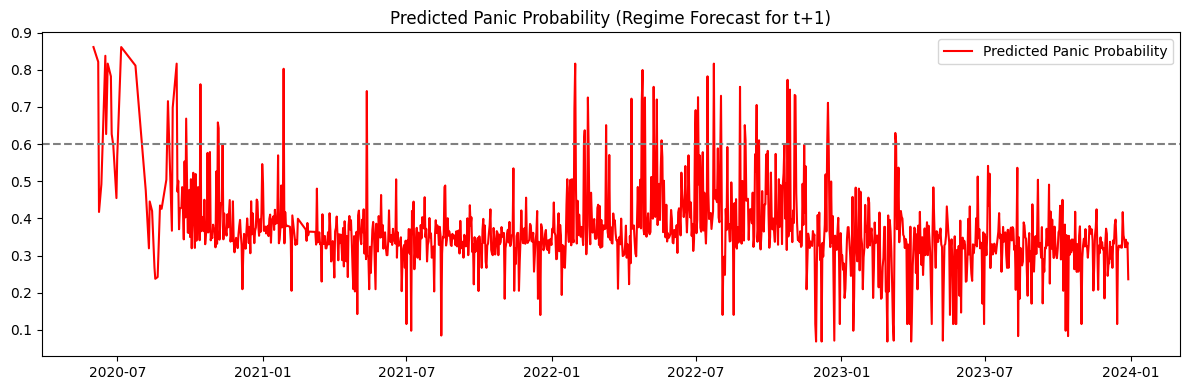

In [643]:
plt.figure(figsize=(12, 4))
plt.plot(classification_df.index, classification_df['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.6, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


In [620]:


classification_df.index = pd.to_datetime(classification_df.index)


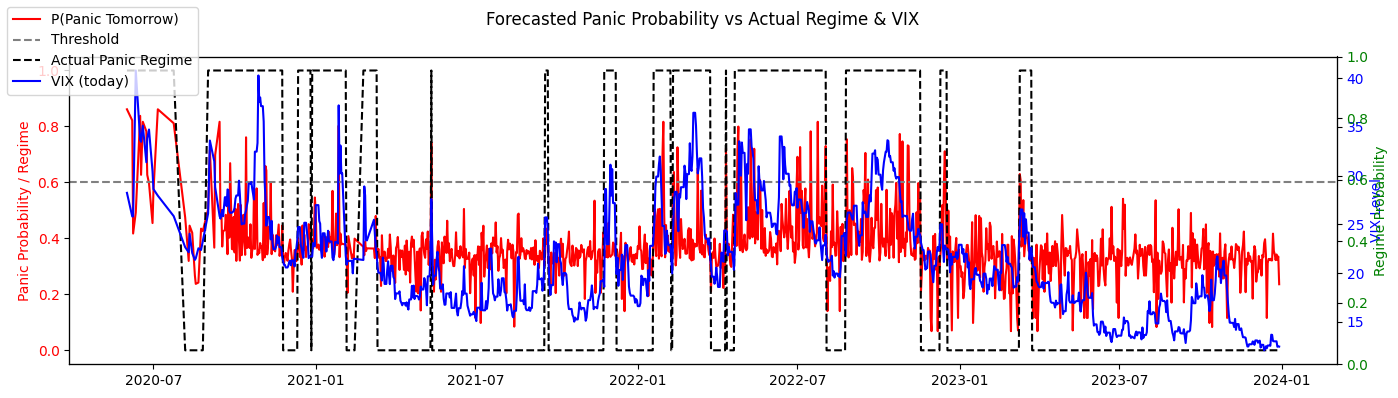

In [621]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.6, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
#ax3.plot(classification_df.index, classification_df['regime_t_raw'], label='Regime Probability', color='green')
ax3.set_ylabel("Regime Probability", color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


for each regime=1, we now get the set of days aferwards to see how vix behaves as soon as the model changes regime

In [687]:
import pandas as pd

def identify_sustained_regimes_and_transitions(classification_df, min_duration=7):
    """
    Identifies sustained regime 1 blocks and transitions in the classification dataframe.

    Args:
    classification_df (pd.DataFrame): DataFrame containing 'regime_t' column (regime states).
    min_duration (int): Minimum duration (in days) for a regime 1 block to be considered valid (default is 7).

    Returns:
    pd.DataFrame: DataFrame with new columns indicating sustained regime 1 and transitions.
    """
    # Step 1: Identify sustained regime 1 blocks (min_duration + consecutive days)
    classification_df['regime_group'] = (classification_df['regime_t'] != classification_df['regime_t'].shift()).cumsum()

    # Group by consecutive regime IDs
    regime_lengths = classification_df.groupby('regime_group')['regime_t'].agg(['first', 'size'])
    
    # Identify valid groups based on 'regime_t' being 1 and duration being >= min_duration
    valid_groups = regime_lengths[(regime_lengths['first'] == 1) & (regime_lengths['size'] >= min_duration)].index

    # Step 2: Only retain regime 1 rows that belong to valid sustained panic groups
    classification_df['is_sustained_regime1'] = classification_df['regime_group'].isin(valid_groups)

    # Step 3: Redefine transitions: 0 → 1 *and* part of a valid (sustained) panic block
    classification_df['regime_t-1'] = classification_df['regime_t'].shift(1)
    classification_df['is_transition'] = (
        (classification_df['regime_t-1'] == 0) &
        (classification_df['regime_t'] == 1) &
        (classification_df['is_sustained_regime1'])
    )

    return classification_df

# Usage example:
# Train dataset (classification_df)
classification_df = identify_sustained_regimes_and_transitions(classification_df)

# Now you can apply it to the test data (test_df) in the same way:




In [679]:
import pandas as pd
import numpy as np

def transform_vix_data(classification_df, window=60):
    """
    Transforms the VIX data into three separate DataFrames for training:
    - VIX windows (future values)
    - Regime windows (future regime states)
    - VIX windows (past values)

    Args:
    classification_df (pd.DataFrame): DataFrame containing the raw classification data with VIX and regimes.
    window (int): The size of the window for future and past data.

    Returns:
    dict: A dictionary containing the transformed DataFrames.
    """
    vix_windows_train = []
    regime_windows_train = []
    vix_windows_past_train = []  # For lookback VIX
    transition_datetimes = []  # To align all three

    # Iterate through the classification_df to extract the relevant windows
    for idx in classification_df[classification_df['is_transition']].index:
        loc = classification_df.index.get_loc(idx)
        
        # Ensure both future and past slices are valid length
        if loc - window < 0 or loc + window > len(classification_df):
            continue

        # Look-ahead VIX + regime
        vix_slice_future = classification_df.iloc[loc:loc + window]["vix_target_t+1"].values
        regime_slice_future = classification_df.iloc[loc:loc + window]["regime_t_raw"].values

        # Lookback VIX (before the transition point)
        vix_slice_past = classification_df.iloc[loc - window:loc]["vix_target"].values

        # Only store if all are full length
        if len(vix_slice_future) == window and len(vix_slice_past) == window:
            vix_windows_train.append(vix_slice_future)
            regime_windows_train.append(regime_slice_future)
            vix_windows_past_train.append(vix_slice_past)
            transition_datetimes.append(idx)

    # Use datetime index for all 3 dataframes
    dt_index = pd.to_datetime(transition_datetimes)

    # Create DataFrames
    vix_windows_df_train = pd.DataFrame(vix_windows_train, index=dt_index)
    regime_windows_df_train = pd.DataFrame(regime_windows_train, index=dt_index)
    vix_windows_past_df_train = pd.DataFrame(vix_windows_past_train, index=dt_index)

    # Set index and column names
    for df in [vix_windows_df_train, regime_windows_df_train, vix_windows_past_df_train]:
        df.index.name = "transition_time"
        df.columns = [f"Day {i}" for i in range(1, window + 1)]

    # Return the three DataFrames
    return {
        "vix_windows_df_train": vix_windows_df_train,
        "regime_windows_df_train": regime_windows_df_train,
        "vix_windows_past_df_train": vix_windows_past_df_train
    }

# Usage Example:
result = transform_vix_data(classification_df, window=60)
vix_windows_df_train = result["vix_windows_df_train"]
regime_windows_df_train = result["regime_windows_df_train"]
vix_windows_past_df_train = result["vix_windows_past_df_train"]


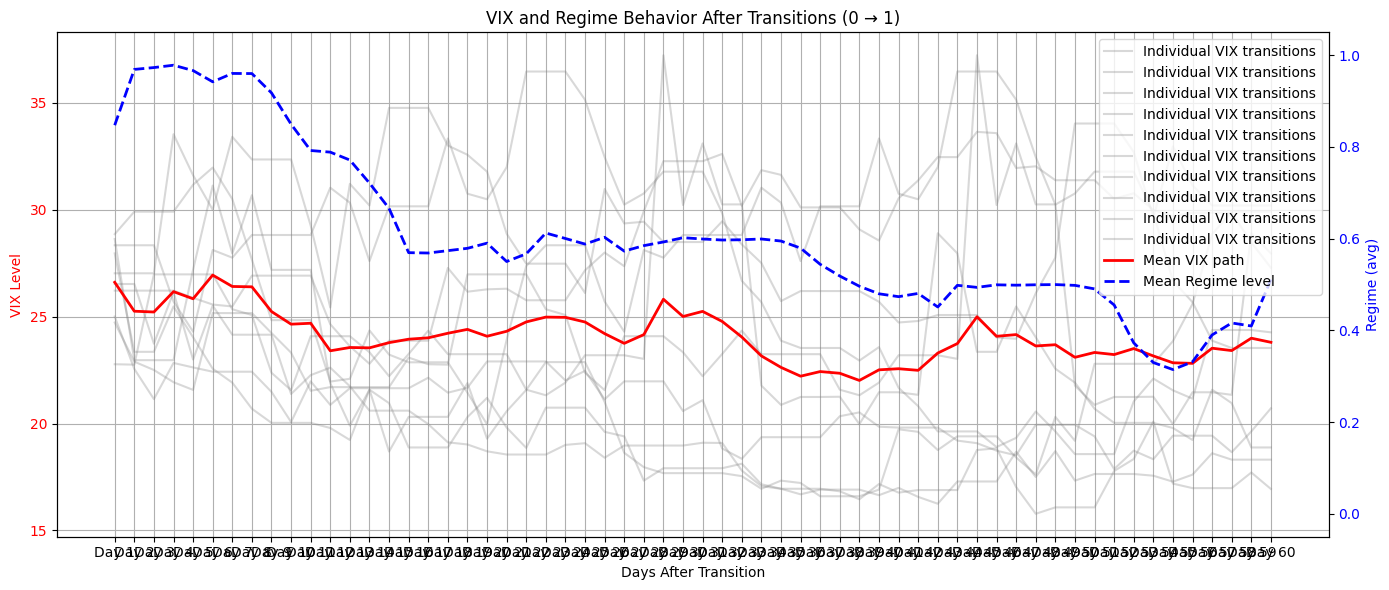

In [680]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_train.T, color="gray", alpha=0.3, label="Individual VIX transitions")
ax1.plot(vix_windows_df_train.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_train.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()



since some spikes happen quite some time after the regime switches, we will build a classifier for 0 (immediate) or 1 (delayed), then feed this into an autoregressive model for vix level forecasting

In [625]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

vix_early = vix_windows_df_train.iloc[:, :30]
vix_late  = vix_windows_df_train.iloc[:, 30:]
vix_start = vix_windows_df_train.iloc[:, 0]

early_spike = (vix_early.max(axis=1) > vix_start * 1.2)
late_spike  = (vix_late.max(axis=1) > vix_start * 1.2)

# Final label: 1 = spike happens early, 0 = spike only late, NaN = no spike
spike_label = pd.Series(np.where(early_spike, 1, np.where(late_spike, 0, np.nan)), index=vix_windows_df_train.index)
spike_label = spike_label.dropna()
valid_indices = spike_label.index

In [698]:
import numpy as np
import pandas as pd

def calculate_pct_changes(df_model, valid_indices, lookback=30, vix_column="vix_target"):
    """
    This function calculates the percentage change in VIX for the given lookback period for valid indices.

    Args:
        df_model (pd.DataFrame): The DataFrame containing VIX data and other features.
        valid_indices (list): List of valid indices for which to calculate percentage change.
        lookback (int): The lookback period for calculating the percentage change.
        vix_column (str): The name of the column containing the VIX values.

    Returns:
        pd.DataFrame: DataFrame of calculated percentage changes with a specified lookback period.
    """
    pct_change_series = []
    used_indices = []

    for idx in valid_indices:
        if idx not in df_model.index:
            continue

        loc = df_model.index.get_loc(idx)
        if loc - lookback - 1 < 0:
            continue  # need one extra point for lookback pct changes

        # Get values for the specified lookback period (including current day)
        vix_window = df_model.iloc[loc - lookback - 1:loc][vix_column]

        if vix_window.isna().any() or len(vix_window) != lookback + 1:
            continue

        # Calculate percentage change over the lookback period
        vix_pct_changes = vix_window.pct_change().iloc[1:].values  # Exclude the first NaN value
        if len(vix_pct_changes) == lookback:
            pct_change_series.append(vix_pct_changes)
            used_indices.append(idx)

    # Final DataFrame (shape: n_transitions × lookback)
    pct_change_df = pd.DataFrame(
        pct_change_series,
        index=pd.to_datetime(used_indices),
        columns=[f"Day -{i}" for i in range(lookback, 0, -1)]
    )

    return pct_change_df, used_indices

# Example Usage:
# Assuming df_model is your DataFrame with 'vix_target' column and valid indices
# valid_indices is a list of valid indices where the transition occurs
vix_pct_change_lookback_df, used_indices = calculate_pct_changes(df_model, valid_indices, lookback=30, vix_column="vix_target")


In [699]:

clf1 = RandomForestClassifier(n_estimators=400, max_depth=7, random_state=42)

y = spike_label.loc[used_indices].astype(int)
clf1.fit(vix_pct_change_lookback_df, y)

early_spike_probs = clf1.predict_proba(vix_pct_change_lookback_df)[:, 1]
vix_windows_df_train.loc[used_indices, "early_spike_prob"] = early_spike_probs



In [700]:
early_spike_probs = clf1.predict_proba(vix_pct_change_lookback_df)[:, 1]
vix_windows_df_train.loc[vix_pct_change_lookback_df.index, "early_spike_prob"] = early_spike_probs



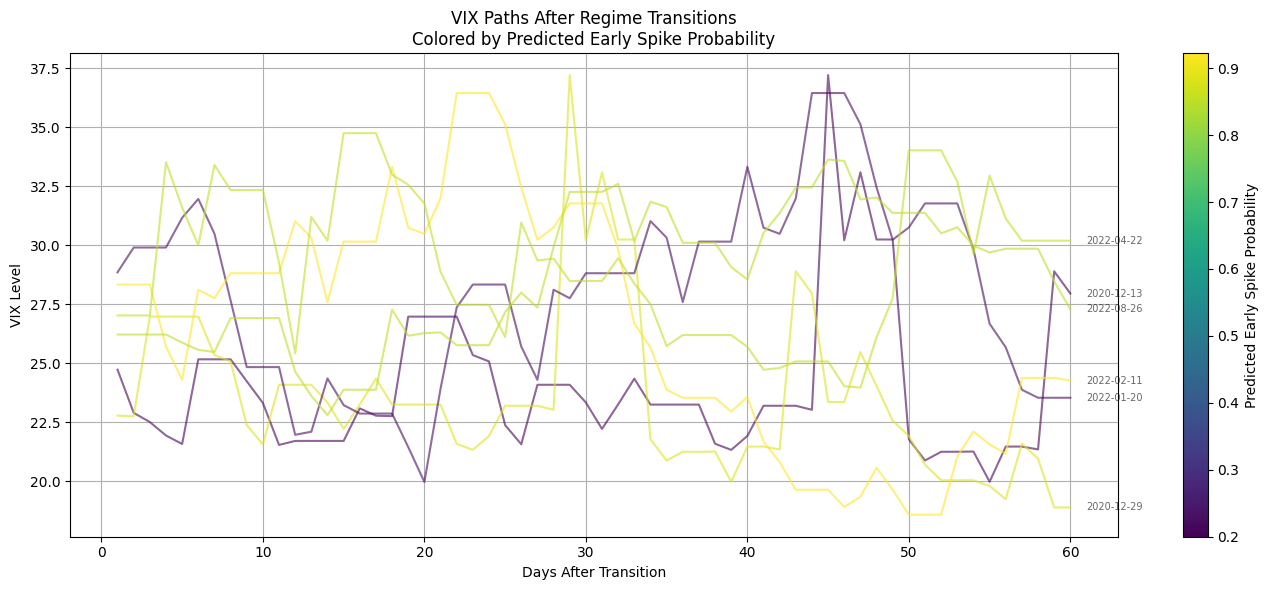

In [701]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = vix_windows_df_train.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [702]:
from sklearn.metrics import roc_auc_score, f1_score

# Get true labels aligned with prediction index
y_true = spike_label.loc[vix_pct_change_lookback_df.index].astype(int)
y_pred = (early_spike_probs > 0.5).astype(int)

print("F1 Score:", f1_score(y_true, y_pred))
print("ROC AUC:", roc_auc_score(y_true, early_spike_probs))


F1 Score: 1.0
ROC AUC: 1.0


In [631]:
# Now we only model the increase in vix (spike itself) and then the decrease

In [655]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd

# Define the spike curve model (asymmetric Gaussian)
def spike_curve(t, A, mu, sigma):
    return A * np.exp(-((t - mu) ** 2) / (2 * sigma ** 2))

# Your spike arc detection function from earlier
def detect_spike_arc(vix_path, search_back=15, min_distance=8):
    vix_path = np.asarray(vix_path, dtype=np.float32)
    peak_idx = int(np.argmax(vix_path))

    if peak_idx == 0:
        sorted_peaks = np.argsort(vix_path)[::-1]
        for alt_peak in sorted_peaks[1:]:
            if alt_peak > 5:
                peak_idx = alt_peak
                break
        else:
            return 0, 0

    window_start = max(0, peak_idx - search_back)
    pre_peak = vix_path[window_start:peak_idx]

    if len(pre_peak) == 0:
        return 0, peak_idx

    local_min_idx = int(np.argmin(pre_peak)) + window_start
    if (peak_idx - local_min_idx) < min_distance:
        global_min_idx = int(np.argmin(vix_path[:peak_idx])) if peak_idx > 0 else 0
        return global_min_idx, peak_idx

    return local_min_idx, peak_idx

In [633]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Initialize containers for long and sharp rises
long_rises_X = []
long_rises_y = []
sharp_rises_X = []
sharp_rises_y = []

# Split the paths
for dt, row in vix_windows_df_train.iterrows():
    vix_path = row[[f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = detect_spike_arc(vix_path)

    if peak_idx <= start_idx + 2:
        continue

    rising = vix_path[start_idx:peak_idx + 1]
    t = np.arange(len(rising)).reshape(-1, 1)

    # Split into sharp and long rises based on the path length
    if len(rising) > 10:
        long_rises_X.append(t)
        long_rises_y.append(rising.reshape(-1, 1))
    else:
        sharp_rises_X.append(t)
        sharp_rises_y.append(rising.reshape(-1, 1))

# Combine datasets for long and sharp rises
long_rises_X_combined = np.vstack(long_rises_X)
long_rises_y_combined = np.vstack(long_rises_y)
sharp_rises_X_combined = np.vstack(sharp_rises_X)
sharp_rises_y_combined = np.vstack(sharp_rises_y)

In [634]:
model_long = LinearRegression()
model_long.fit(long_rises_X_combined, long_rises_y_combined)
y_pred_long = model_long.predict(long_rises_X_combined)

# Fit linear regression for sharp rises
model_sharp = LinearRegression()
model_sharp.fit(sharp_rises_X_combined, sharp_rises_y_combined)
y_pred_sharp = model_sharp.predict(sharp_rises_X_combined)


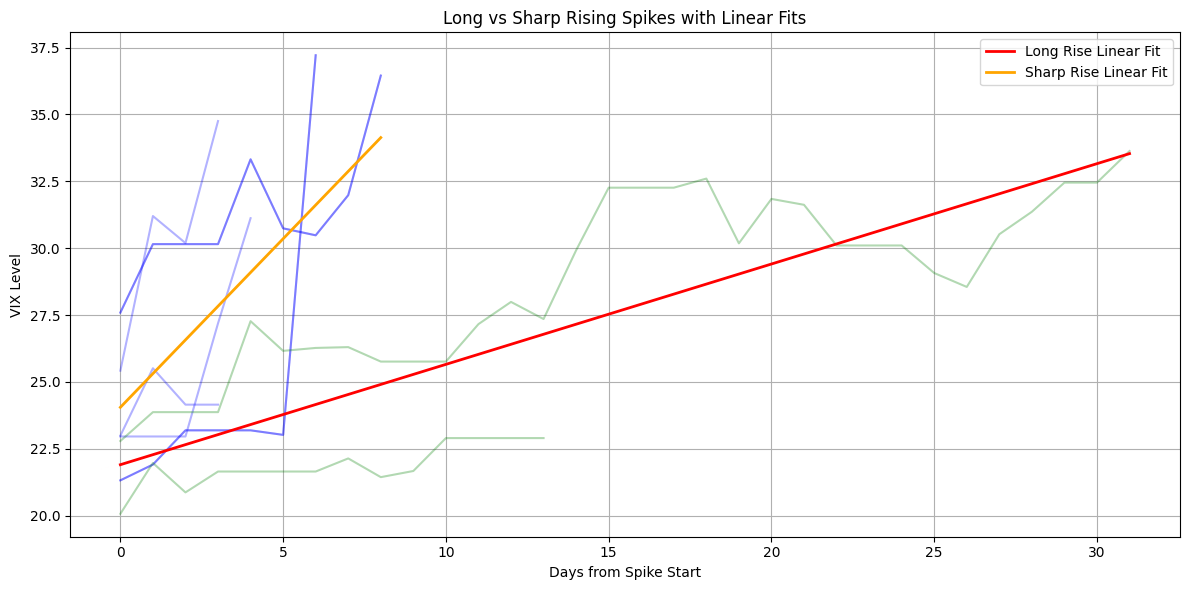

In [635]:
plt.figure(figsize=(12, 6))

# Plot sharp rises (blue)
for i in range(len(sharp_rises_X)):
    plt.plot(sharp_rises_X[i], sharp_rises_y[i], alpha=0.3, color='blue')

# Plot long rises (green)
for i in range(len(long_rises_X)):
    plt.plot(long_rises_X[i], long_rises_y[i], alpha=0.3, color='green')

# Plot long rise regression (red)
plt.plot(np.sort(long_rises_X_combined.flatten()), 
         model_long.predict(np.sort(long_rises_X_combined, axis=0)), 
         color='red', linewidth=2, label='Long Rise Linear Fit')

# Plot sharp rise regression (orange)
plt.plot(np.sort(sharp_rises_X_combined.flatten()), 
         model_sharp.predict(np.sort(sharp_rises_X_combined, axis=0)), 
         color='orange', linewidth=2, label='Sharp Rise Linear Fit')

plt.title("Long vs Sharp Rising Spikes with Linear Fits")
plt.xlabel("Days from Spike Start")
plt.ylabel("VIX Level")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# now we fit an NN

# Test Set on models (regime + panic probability)


In [ ]:
vix_windows_df_train

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2020-09-03,31.459999,28.809999,25.850000,25.590000,26.040001,26.459999,25.830000,27.780001,27.780001,26.860001,...,37.130001,35.549999,29.570000,27.580000,24.860001,25.750000,25.750000,25.750000,24.799999,23.450001
2020-12-13,24.719999,22.889999,22.500000,21.930000,21.570000,25.160000,25.160000,25.160000,24.230000,23.309999,...,20.870001,21.240000,21.240000,21.250000,19.969999,21.459999,21.459999,21.340000,28.889999,27.950001
2020-12-29,22.770000,22.750000,26.969999,26.969999,26.969999,26.969999,25.340000,25.070000,22.370001,21.559999,...,20.690001,20.030001,20.030001,20.030001,19.790001,19.230000,21.580000,20.950001,18.879999,18.879999
2021-02-25,27.950001,23.350000,23.350000,25.469999,24.030001,22.559999,21.910000,20.690001,20.030001,20.030001,...,17.639999,17.639999,17.639999,17.559999,17.280001,17.610001,18.610001,18.309999,18.309999,18.309999
2021-11-25,28.620001,22.959999,22.959999,22.959999,27.190001,31.120001,27.950001,30.670000,27.180000,27.180000,...,22.790001,22.790001,22.790001,22.790001,23.850000,25.590000,28.850000,29.900000,29.900000,29.900000
2022-01-20,28.850000,29.900000,29.900000,29.900000,31.160000,31.959999,30.490000,27.660000,24.830000,24.830000,...,31.770000,31.770000,31.770000,29.830000,26.670000,25.670000,23.870001,23.530001,23.530001,23.530001
2022-02-11,28.330000,28.330000,28.330000,25.700001,24.290001,28.110001,27.750000,28.809999,28.809999,28.809999,...,18.570000,18.570000,21.030001,22.100000,21.549999,21.160000,24.370001,24.370001,24.370001,24.260000
2022-04-22,27.020000,27.020000,27.020000,33.520000,31.600000,29.990000,33.400002,32.340000,32.340000,32.340000,...,34.020000,34.020000,32.689999,29.620001,32.950001,31.129999,30.190001,30.190001,30.190001,30.190001
2022-08-26,26.209999,26.209999,26.209999,26.209999,25.870001,25.559999,25.469999,26.910000,26.910000,26.910000,...,31.370001,30.500000,30.760000,29.980000,29.690001,29.850000,29.850000,29.850000,28.459999,27.280001


In [692]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)
test_df = test_df.dropna(subset=selected_features + ['vix_target_t+1']).copy()

X_test = test_df[selected_features]
y_test = test_df['vix_target_t+1']



# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
test_df['regime_t'] = results_test.filtered_marginal_probabilities[1].apply(lambda p: 1 if p >= 0.005 else 0)
test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf0.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['panic_prob_t+1'] = test_df['panic_prob_t+1'].shift(1)
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)




/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


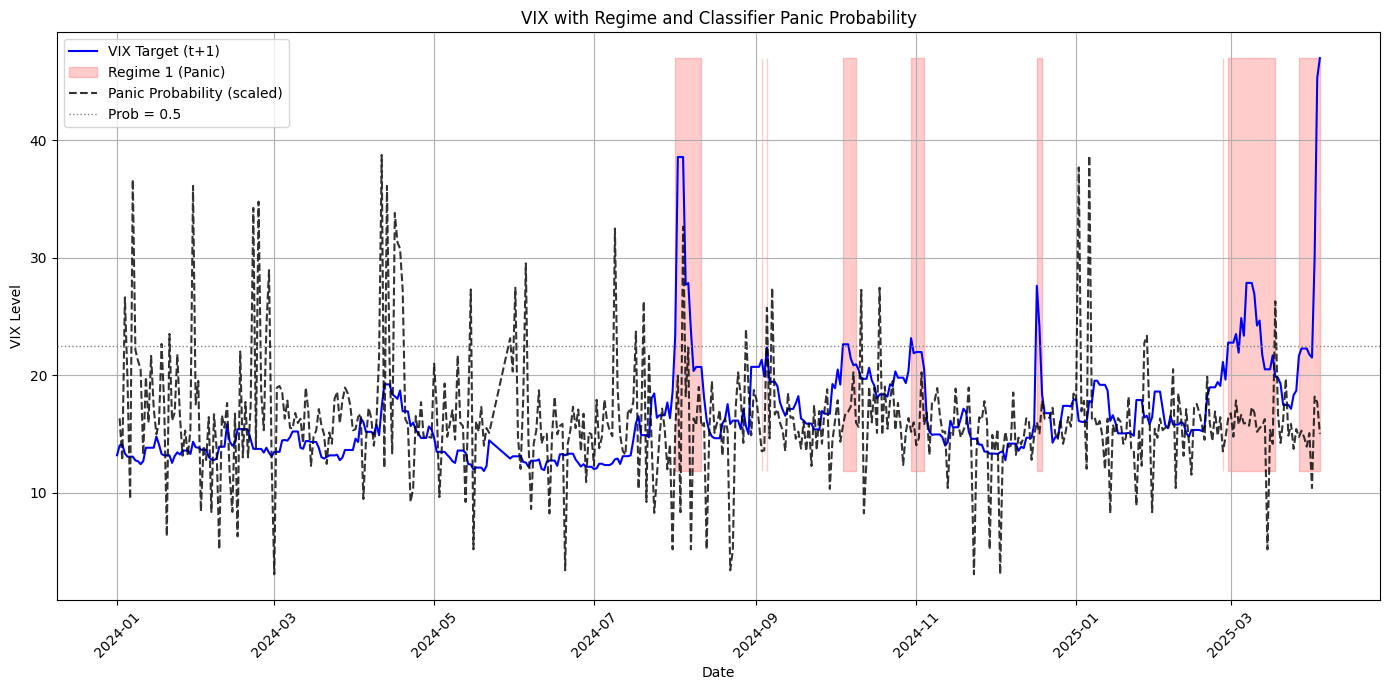

In [646]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Markov Switching Auto Regressive model

In [214]:
regime_0_df = df_model[df_model['regime_t'] == 0]
regime_1_df = df_model[df_model['regime_t'] == 1]

In [215]:
from statsmodels.tsa.ar_model import AutoReg

ar_regime_0 = AutoReg(regime_0_df['vix_target'], lags=1, trend='c').fit()
ar_regime_1 = AutoReg(regime_1_df['vix_target'], lags=1, trend='c').fit()

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [216]:
import numpy as np
def forecast_vix_autoreg(current_vix, current_regime):
    phi = ar_regime_0.params if current_regime == 0 else ar_regime_1.params
    forecast = phi['const'] + phi['vix_target.L1'] * current_vix
    return forecast

In [217]:
sigma_0 = np.std(ar_regime_0.resid)
sigma_1 = np.std(ar_regime_1.resid)

phi_0 = ar_regime_0.params
phi_1 = ar_regime_1.params

transition_matrix_forecast = transition_matrix #from our first model

initial_regime = df_model['regime_t'].iloc[-1]  # last predicted regime


In [218]:
first_panic = test_df[test_df['regime_t'] == 1].iloc[0]
print(first_panic['vix_target'])


18.59000015258789


In [219]:
# Step 1: Detect regime transitions (0 → 1)
test_df['regime_t-1'] = test_df['regime_t'].shift(1)
test_df['is_transition'] = (test_df['regime_t-1'] == 0) & (test_df['regime_t'] == 1)



In [220]:
test_df[test_df['is_transition']]

,Unnamed: 0,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore,vix_target_t+1,regime_t,panic_prob_t+1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-08-01,1703,2024-08-01,-0.292869,-0.973897,0.947609,65,99,-0.278619,-0.974209,0.950001,...,-0.974053,-34,1,0.283840,1.867475,23.389999,1,0.477831,0.0,True
2024-09-03,1736,2024-09-03,-0.033295,-0.969301,0.948438,106,54,-0.090644,-0.966677,0.939915,...,-0.967989,52,0,0.414334,0.340104,21.320000,1,0.489463,0.0,True
2024-09-05,1738,2024-09-05,-0.127234,-0.968873,0.949641,210,91,-0.040936,-0.975435,0.943705,...,-0.972154,119,0,0.223110,0.550898,22.379999,1,0.514686,0.0,True
2024-10-04,1767,2024-10-04,-0.161758,-0.974880,0.956488,25,24,-0.179731,-0.966917,0.948299,...,-0.970898,1,0,0.176362,0.892619,22.639999,1,0.466187,0.0,True
2024-10-30,1793,2024-10-30,-0.023059,-0.976818,0.955613,42,27,-0.070288,-0.969683,0.952119,...,-0.973251,15,0,-0.014050,0.358336,23.160000,1,0.493824,0.0,True
2024-12-17,1841,2024-12-17,-0.200720,-0.973212,0.951735,128,95,-0.080458,-0.973030,0.951784,...,-0.973121,33,0,0.189655,1.374896,27.620001,1,0.493454,0.0,True
2025-02-28,1914,2025-02-28,-0.178687,-0.975512,0.954631,75,60,-0.157563,-0.966205,0.952781,...,-0.970858,15,0,0.300000,1.494880,22.780001,1,0.475647,0.0,True
2025-03-27,1941,2025-03-27,-0.116046,-0.972738,0.951299,190,97,-0.160304,-0.974677,0.947820,...,-0.973707,93,0,-0.228642,-0.946713,21.650000,1,0.472414,0.0,True


In [221]:
# Step 2: Store 15-day windows of VIX after each transition
window = 5
vix_windows = []

for idx in test_df[test_df['is_transition']].index:
    # Get position of the index
    loc = test_df.index.get_loc(idx)
    # Slice the 15 days following the transition (including the day itself)
    vix_slice = test_df.iloc[loc:loc + window]['vix_target_t+1'].values
    # Only store windows with full length (some at end of data may be shorter)
    if len(vix_slice) == window:
        vix_windows.append(vix_slice)

# Step 3: Convert to DataFrame for analysis/plotting
vix_windows_df = pd.DataFrame(vix_windows)
vix_windows_df.index.name = "Transition #"
vix_windows_df.columns = [f"Day {i}" for i in range(1, window + 1)]

In [222]:
vix_windows_df

,Day 1,Day 2,Day 3,Day 4,Day 5
Transition #,,,,,
0,23.389999,38.570000,38.570000,38.570000,27.709999
1,21.320000,19.900000,22.379999,19.450001,19.450001
2,22.379999,19.450001,19.450001,19.450001,19.080000
3,22.639999,22.639999,22.639999,21.420000,20.860001
4,23.160000,21.879999,21.980000,21.980000,21.980000
5,27.620001,24.090000,18.360001,16.780001,16.780001
6,22.780001,22.780001,22.780001,23.510000,21.930000
7,21.650000,22.280001,22.280001,22.280001,21.770000


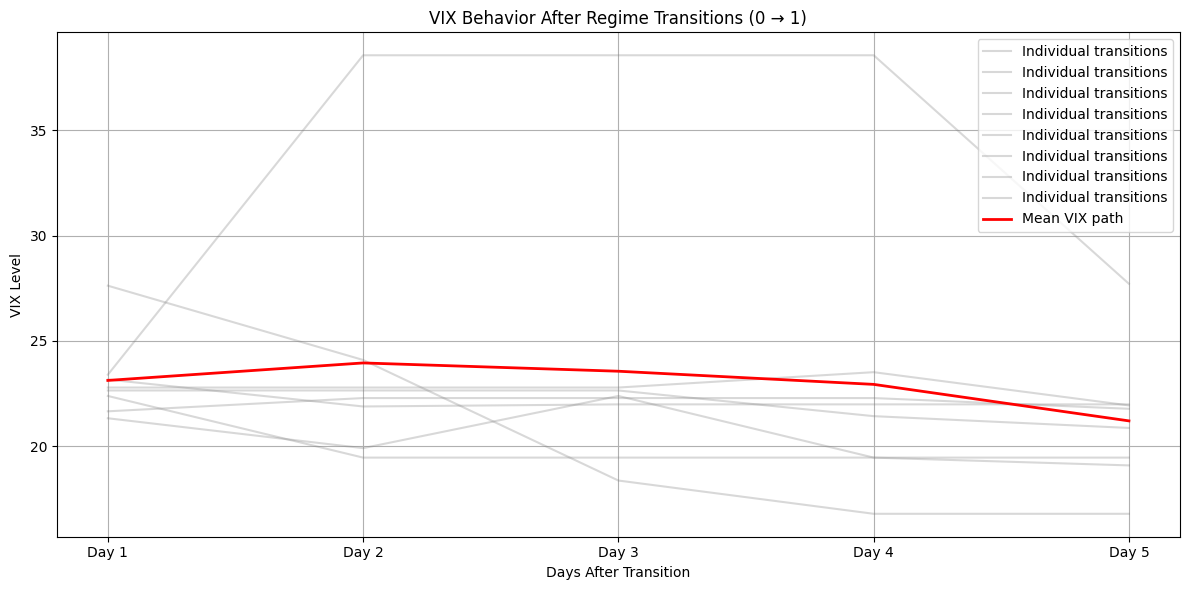

In [223]:
plt.figure(figsize=(12, 6))
plt.plot(vix_windows_df.T, color="gray", alpha=0.3, label="Individual transitions")
plt.plot(vix_windows_df.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")

plt.title("VIX Behavior After Regime Transitions (0 → 1)")
plt.xlabel("Days After Transition")
plt.ylabel("VIX Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/794786639.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_0[phi_0.index.str.contains('L1')][0]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/794786639.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_1[phi_1.index.str.contains('L1')][0]


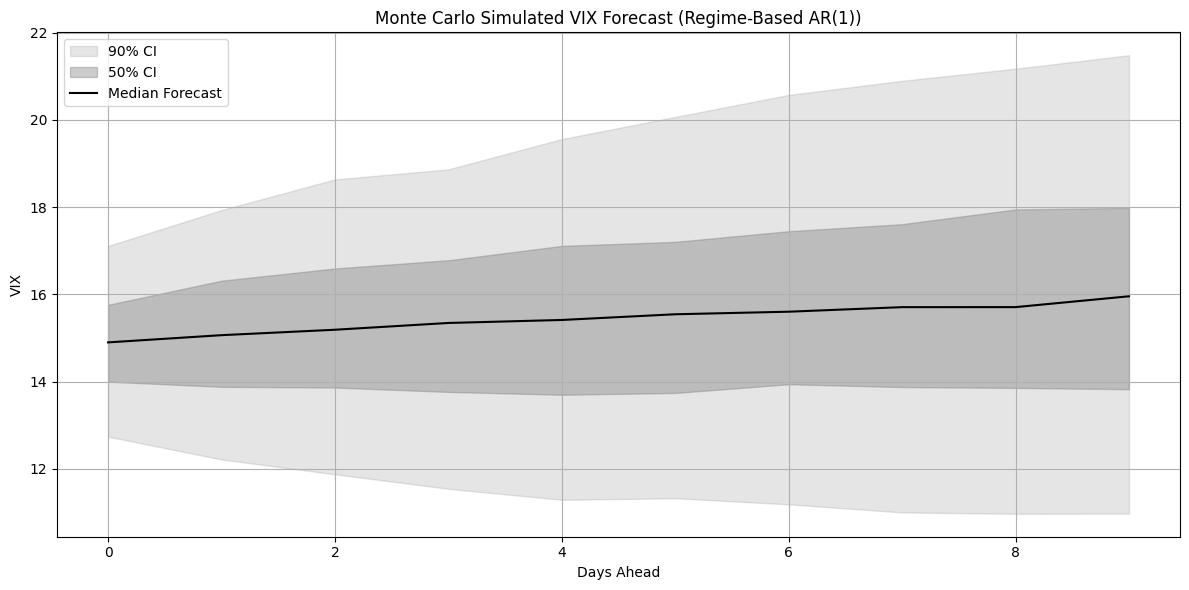

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_vix_paths_ar(n_days=30, n_paths=1000, start_val=20, start_regime=0,
                          phi_0=None, phi_1=None,
                          sigma_0=1.0, sigma_1=1.0,
                          transition_matrix=None):
    paths = np.zeros((n_paths, n_days))
    regimes = np.zeros((n_paths, n_days), dtype=int)

    for i in range(n_paths):
        vix = start_val
        regime = start_regime

        for t in range(n_days):
            # Transition to next regime
            regime = np.random.choice([0, 1], p=transition_matrix[regime])
            regimes[i, t] = regime

            if regime == 0:
                const = phi_0['const']
                phi = phi_0[phi_0.index.str.contains('L1')][0]
                shock = np.random.normal(0, sigma_0)
                vix = const + phi * vix + shock
            else:
                const = phi_1['const']
                phi = phi_1[phi_1.index.str.contains('L1')][0]
                shock = np.random.normal(0, sigma_1)
                vix = const + phi * vix + shock

            paths[i, t] = vix

    return paths, regimes

# === Run the simulation ===
first_panic = test_df[test_df['regime_t'] == 1].iloc[0]
first_panic = first_panic['vix_target']
#start_vix = test_df['vix_target_t+1'].iloc[0]
sim_paths, sim_regimes = simulate_vix_paths_ar(
    n_days=10,
    n_paths=1000,
    start_val=first_panic,
    start_regime=initial_regime,
    phi_0=phi_0,
    phi_1=phi_1,
    sigma_0=sigma_0,
    sigma_1=sigma_1,
    transition_matrix=transition_matrix_forecast
)

# === Plot fan chart ===
percentiles = np.percentile(sim_paths, [5, 25, 50, 75, 95], axis=0)
days = np.arange(sim_paths.shape[1])

plt.figure(figsize=(12, 6))
plt.fill_between(days, percentiles[0], percentiles[-1], color='gray', alpha=0.2, label='90% CI')
plt.fill_between(days, percentiles[1], percentiles[-2], color='gray', alpha=0.4, label='50% CI')
plt.plot(days, percentiles[2], color='black', label='Median Forecast')
plt.title("Monte Carlo Simulated VIX Forecast (Regime-Based AR(1))")
plt.xlabel("Days Ahead")
plt.ylabel("VIX")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [34]:
forecast_horizon = 30
expected_paths = []

# Loop through each test point where regime == 1
for idx in range(len(test_df) - forecast_horizon):
    row = test_df.iloc[idx]
    if row['regime_t'] == 1:
        vix_start = row['vix_target_t+1']
        regime_start = row['regime_t']

        # Simulate forecasts from this point
        sim_paths, _ = simulate_vix_paths_ar(
            n_days=forecast_horizon,
            n_paths=1000,
            start_val=vix_start,
            start_regime=regime_start,
            phi_0=phi_0,
            phi_1=phi_1,
            sigma_0=sigma_0,
            sigma_1=sigma_1,
            transition_matrix=transition_matrix_forecast
        )

        # Use expected value (mean forecast) — or replace with np.median(...) if preferred
        expected_path = np.mean(sim_paths, axis=0)

        # Align with index
        future_dates = test_df.index[idx:idx + forecast_horizon]
        if len(future_dates) == forecast_horizon:
            expected_paths.append((future_dates, expected_path))

# === Plot ===
plt.figure(figsize=(14, 7))

# Plot actual VIX
plt.plot(test_df.index, test_df["vix_target_t+1"], label="VIX Target (t+1)", color="blue")

# Highlight panic regime areas
plt.fill_between(
    test_df.index,
    test_df["vix_target_t+1"].min(),
    test_df["vix_target_t+1"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# Plot scaled panic probability
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target_t+1"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)
plt.axhline(y=0.5 * (test_df["vix_target_t+1"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Plot expected forecast paths (mean or median)
for dates, path in expected_paths:
    plt.plot(dates, path, color="green", alpha=0.7, linewidth=1.8, label="Expected VIX Forecast" if 'Expected VIX Forecast' not in plt.gca().get_legend_handles_labels()[1] else "")

# Finalize
plt.title("Expected VIX Forecasts During Panic Regimes")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/1077054220.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_1[phi_1.index.str.contains('L1')][0]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_92478/1077054220.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  phi = phi_0[phi_0.index.str.contains('L1')][0]


KeyboardInterrupt: 

# XGboost model

In [26]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



